# Oxygen Anomaly Detection – Improved Pipeline & Output Analysis

This notebook does two things:

1. **Defines an improved version of the generic anomaly detection pipeline** for minute-level oxygen readings, with a small refinement to the *high-noise* sensor-fault detection logic.
2. **Performs a detailed analysis** of an already-scored anomaly output file (e.g. `subset.csv`) generated by the pipeline, including:
   - Severity distribution
   - Performance vs synthetic labels
   - Per-type & per-sensor behaviour
   - Threshold-based precision/recall summaries

You can either:

- Use your existing scored output (`subset.csv`, `scored.csv`, etc.), or
- Run the pipeline section here to generate a fresh scored dataset and analyse that.


In [1]:
# %% Imports & plotting config

import numpy as np
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

from dataclasses import dataclass

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# %% Anomaly config dataclass

@dataclass
class AnomalyConfig:
    # Rolling windows (in minutes)
    roll_window_baseline: int = 60           # 1-hour baseline
    roll_window_collective: int = 120        # 2-hour window for collective anomalies
    roll_window_stuck: int = 60              # 1-hour rolling std for 'stuck'
    roll_window_noise: int = 60              # 1-hour rolling std for 'noise'

    # Point / contextual anomaly z-score thresholds for score scaling
    z_point_low: float = 2.0                 # start increasing score
    z_point_high: float = 5.0                # max severity for point anomalies
    z_ctx_low: float = 2.0
    z_ctx_high: float = 4.0

    # Collective anomaly thresholds (mean |z| over a window)
    collective_low: float = 1.0
    collective_high: float = 3.0

    # Sensor-fault parameters
    stuck_rel_std_factor: float = 0.1        # local std < 0.1 * typical std ⇒ stuck
    noise_factor: float = 1.5                # local std > 1.5 * baseline std ⇒ noisy (more sensitive)
    spike_z_threshold: float = 3.0           # how many std-devs for spikes

    # Small epsilon for numerical stability
    eps: float = 1e-6


In [4]:
# %% Helper functions: loading and preparation

def load_oxygen_csv(csv_path: str) -> pd.DataFrame:
    """
    Load the raw oxygen CSV.
    Assumes columns: time, Oxygen[%sat], EquipmentUnit, SubUnit, System, Unit.
    """
    df = pd.read_csv(csv_path)
    # Parse time
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    return df


def prepare_sensor_frame(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare a generic sensor frame:

    - Drop rows with missing Oxygen.
    - Create a generic sensor_id that does NOT rely on tag semantics.
    - Keep only (time, sensor_id, value, basic time features).
    """
    df = df_raw.copy()

    # Keep only rows where Oxygen is present
    df = df[df['time'].notna() & df["Oxygen[%sat]"].notna()].copy()

    # Generic sensor id: we just use tags as opaque identifiers.
    # This will still generalize to new customers & tag values.
    df["sensor_id"] = (
        df["System"].astype(str)
        + "|"
        + df["EquipmentUnit"].astype(str)
        + "|"
        + df["SubUnit"].astype(str)
    )

    df.rename(columns={"Oxygen[%sat]": "oxygen"}, inplace=True)

    # Basic time features for contextual anomalies
    df["hour"] = df["time"].dt.hour
    df["dayofweek"] = df["time"].dt.dayofweek

    # Sort by sensor and time to make rolling operations valid
    df = df.sort_values(["sensor_id", "time"]).reset_index(drop=True)

    return df[["time", "sensor_id", "oxygen", "hour", "dayofweek"]]


def squash_z(z: pd.Series, low: float, high: float) -> pd.Series:
    """
    Map |z| to [0, 1] linearly between `low` and `high`.

    - |z| <= low  => 0
    - |z| >= high => 1
    - between     => linear ramp
    """
    az = z.abs()
    return ((az - low) / (high - low)).clip(lower=0.0, upper=1.0)


In [5]:
# %% Components: baseline and point anomalies

def add_baseline_and_point_scores(df: pd.DataFrame, cfg: AnomalyConfig) -> pd.DataFrame:
    """
    For each sensor_id:
    - Compute rolling baseline (mean + std) over `roll_window_baseline`.
    - Compute standardized residual z-score.
    - Compute point anomaly score from z-score.
    """
    df = df.copy()
    g = df.groupby("sensor_id", group_keys=False)

    # Rolling mean & std as local baseline
    df["roll_mean"] = g["oxygen"].transform(
        lambda s: s.rolling(
            window=cfg.roll_window_baseline,
            min_periods=cfg.roll_window_baseline // 2
        ).mean()
    )
    df["roll_std"] = g["oxygen"].transform(
        lambda s: s.rolling(
            window=cfg.roll_window_baseline,
            min_periods=cfg.roll_window_baseline // 2
        ).std()
    )

    # Standardized residual (z-score vs rolling baseline)
    df["z_global"] = (df["oxygen"] - df["roll_mean"]) / (df["roll_std"] + cfg.eps)

    # Point anomaly score
    df["score_point"] = squash_z(df["z_global"], cfg.z_point_low, cfg.z_point_high)

    return df


In [6]:
# %% Components: collective anomalies

def add_collective_scores(df: pd.DataFrame, cfg: AnomalyConfig) -> pd.DataFrame:
    """
    Collective anomalies: sequences where residuals are consistently large.

    We use rolling mean(|z_global|) over a larger window, then scale.
    """
    df = df.copy()
    g = df.groupby("sensor_id", group_keys=False)

    df["roll_mean_abs_z"] = g["z_global"].transform(
        lambda s: s.abs().rolling(
            window=cfg.roll_window_collective,
            min_periods=cfg.roll_window_collective // 2
        ).mean()
    )

    df["score_collective"] = (
        (df["roll_mean_abs_z"] - cfg.collective_low)
        / (cfg.collective_high - cfg.collective_low)
    ).clip(lower=0.0, upper=1.0)

    return df


In [7]:
# %% Components: contextual anomalies

def add_contextual_scores(df: pd.DataFrame, cfg: AnomalyConfig) -> pd.DataFrame:
    """
    Contextual anomalies: values unusual for their context (e.g. hour-of-day).

    Here we build a simple global "expected" oxygen per (hour) across all sensors
    and compute z-score vs that contextual expectation.
    """
    df = df.copy()

    # Contextual baseline: global per-hour stats
    ctx_stats = (
        df.groupby("hour")["oxygen"]
        .agg(["mean", "std"])
        .rename(columns={"mean": "ctx_mean_hour", "std": "ctx_std_hour"})
    )

    df = df.join(ctx_stats, on="hour")

    # Contextual z-score
    df["z_context"] = (df["oxygen"] - df["ctx_mean_hour"]) / (df["ctx_std_hour"] + cfg.eps)

    # Contextual anomaly score
    df["score_context"] = squash_z(df["z_context"], cfg.z_ctx_low, cfg.z_ctx_high)

    return df

In [8]:
# %% Components: sensor-fault anomalies (stuck, spikes, high noise)

def add_sensor_fault_scores(df: pd.DataFrame, cfg: AnomalyConfig) -> pd.DataFrame:
    """
    Sensor fault anomalies include:
    - Stuck sensor: very low local variance compared to typical variance.
    - Spikes/glitches: sharp jumps and immediate reversals.
    - High noise: local variance much higher than typical.

    We compute three sub-scores and take their max as sensor_fault score.
    """
    df = df.copy()
    g = df.groupby("sensor_id", group_keys=False)

    # --- Overall typical stats per sensor for comparison ---
    sensor_std = g["oxygen"].transform("std")           # typical volatility
    sensor_diff_std = g["oxygen"].transform(lambda s: s.diff().std())

    # --- Rolling std over larger window: used for stuck & noise ---
    df["roll_std_long"] = g["oxygen"].transform(
        lambda s: s.rolling(
            window=cfg.roll_window_stuck,
            min_periods=cfg.roll_window_stuck // 2
        ).std()
    )

    # 6.1 Stuck sensor score
    # If local std is much smaller than typical std, we suspect stuck behaviour.
    # Score grows as roll_std_long / sensor_std goes towards 0.
    ratio_std = df["roll_std_long"] / (sensor_std + cfg.eps)
    # We want large score when ratio_std is very small (< stuck_rel_std_factor)
    df["score_stuck"] = (cfg.stuck_rel_std_factor - ratio_std) / cfg.stuck_rel_std_factor
    df["score_stuck"] = df["score_stuck"].clip(lower=0.0, upper=1.0)

    # 6.2 Spikes / glitches score
    # Look for a large jump followed by a reversal.
    diff_prev = g["oxygen"].diff()
    diff_next = -g["oxygen"].diff(-1)  # difference to next point, negated to compare sign
    spike_mag = np.minimum(diff_prev.abs(), diff_next.abs())

    # normalized spike magnitude
    spike_norm = spike_mag / (sensor_diff_std + cfg.eps)
    # candidate spikes: sign reversal + big magnitude
    candidate_spike = (diff_prev * diff_next < 0) & (spike_norm > cfg.spike_z_threshold)

    df["score_spike"] = 0.0
    df.loc[candidate_spike, "score_spike"] = (
        (spike_norm[candidate_spike] - cfg.spike_z_threshold) / cfg.spike_z_threshold
    ).clip(upper=1.0)

    # 6.3 High noise score
    # If local std is much higher than typical std, we suspect high noise.
    df["roll_std_noise"] = g["oxygen"].transform(
        lambda s: s.rolling(
            window=cfg.roll_window_noise,
            min_periods=cfg.roll_window_noise // 2
        ).std()
    )
    noise_ratio = df["roll_std_noise"] / (sensor_std + cfg.eps)
    df["score_noise"] = (noise_ratio - 1.0) / (cfg.noise_factor - 1.0)
    df["score_noise"] = df["score_noise"].clip(lower=0.0, upper=1.0)

    # Combine into a single sensor_fault score
    df["score_sensor_fault"] = df[["score_stuck", "score_spike", "score_noise"]].max(axis=1)

    return df

In [9]:
# %% Optional: synthetic anomaly injection (for testing)

def inject_synthetic_anomalies(
    df: pd.DataFrame,
    n_point_spikes: int = 20,
    n_collective_dips: int = 5,
    stuck_length: int = 60,
    noise_length: int = 60,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Injects synthetic anomalies into a copy of df for illustration and testing.

    - Random large spikes (point anomalies)
    - Random dips over short windows (collective)
    - Stuck segments (constant value)
    - High-noise segments

    Adds a column `synthetic_label` with one of:
    - 'normal'
    - 'syn_point_spike'
    - 'syn_collective_dip'
    - 'syn_stuck'
    - 'syn_high_noise'
    """
    rng = np.random.default_rng(random_state)
    df = df.copy()
    df["synthetic_label"] = "normal"

    # Work sensor-by-sensor to keep indexing simple
    for sensor_id, df_s in df.groupby("sensor_id"):
        idx = df_s.index.to_numpy()
        n = len(idx)
        if n < 1000:
            continue  # skip very short series

        # 7.1 Inject point spikes
        for _ in range(n_point_spikes):
            i = int(rng.integers(0, n))
            row_idx = idx[i]
            # Add a large positive or negative spike
            sign = rng.choice([-1, 1])
            magnitude = rng.uniform(20, 40)  # adjust as desired
            df.loc[row_idx, "oxygen"] += sign * magnitude
            df.loc[row_idx, "synthetic_label"] = "syn_point_spike"

        # 7.2 Inject collective dips (sequence anomalies)
        for _ in range(n_collective_dips):
            start = int(rng.integers(0, n - 120))
            length = rng.integers(30, 120)  # 30–120 minutes
            segment_idx = idx[start : start + length]
            df.loc[segment_idx, "oxygen"] *= rng.uniform(0.6, 0.8)  # dip
            df.loc[segment_idx, "synthetic_label"] = "syn_collective_dip"

        # 7.3 Inject stuck sensor segments
        # pick a start where we have enough space
        start = int(rng.integers(0, n - stuck_length))
        segment_idx = idx[start : start + stuck_length]
        stuck_value = float(df.loc[segment_idx[0], "oxygen"])
        df.loc[segment_idx, "oxygen"] = stuck_value
        df.loc[segment_idx, "synthetic_label"] = "syn_stuck"

        # 7.4 Inject high-noise segment
        start = int(rng.integers(0, n - noise_length))
        segment_idx = idx[start : start + noise_length]
        base = df.loc[segment_idx, "oxygen"]
        df.loc[segment_idx, "oxygen"] = base + rng.normal(
            0, base.std() * 2.0, size=len(segment_idx)
        )
        df.loc[segment_idx, "synthetic_label"] = "syn_high_noise"

    return df

In [10]:
# %% Combine sub-scores into overall severity

def add_severity_score(df: pd.DataFrame) -> pd.DataFrame:
    """
    Combine all sub-scores into a single anomaly severity score in [0, 1].

    We take the max of:
    - point
    - collective
    - contextual
    - sensor_fault
    """
    df = df.copy()
    score_cols = [
        "score_point",
        "score_collective",
        "score_context",
        "score_sensor_fault",
    ]
    df["severity"] = df[score_cols].max(axis=1)
    return df


In [11]:
# %% OxygenAnomalyDetector class

class OxygenAnomalyDetector:
    """Wrapper around the anomaly pipeline (improved noise detection)."""

    def __init__(self, cfg: AnomalyConfig | None = None):
        self.cfg = cfg or AnomalyConfig()
        self.fitted_ = False

    def fit(self, df_raw: pd.DataFrame):
        """For this rule-based detector, `fit` is a no-op (kept for symmetry)."""
        self.fitted_ = True
        return self

    def score(self, df_raw: pd.DataFrame, inject_synthetic: bool = False) -> pd.DataFrame:
        """Run the full anomaly detection pipeline on df_raw."""
        if not self.fitted_:
            raise RuntimeError("Call `fit(df_raw)` before `score(df_raw)`.")

        df = prepare_sensor_frame(df_raw)

        if inject_synthetic:
            df = inject_synthetic_anomalies(df)

        df = add_baseline_and_point_scores(df, self.cfg)
        df = add_collective_scores(df, self.cfg)
        df = add_contextual_scores(df, self.cfg)
        df = add_sensor_fault_scores(df, self.cfg)
        df = add_severity_score(df)

        return df

In [12]:
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" , "data"))
DATA_RAW_DIR = Path(os.path.join(DATA_DIR, "raw"))
DATA_PROCESSED_DIR = Path(os.path.join(DATA_DIR, "processed"))
# Path to the dataset (adjust this if needed)
processed_path = Path(os.path.join(DATA_PROCESSED_DIR, "oxygen_processed.csv"))
raw_path = Path(os.path.join(DATA_RAW_DIR, "oxygen.csv"))

In [13]:
# %% Load raw oxygen dataset

df_raw = load_oxygen_csv(raw_path)

df_raw.head()
df_raw.dtypes

time             datetime64[ns]
Oxygen[%sat]            float64
EquipmentUnit            object
SubUnit                  object
System                   object
Unit                     object
dtype: object

In [14]:
# %% Instantiate and fit the detector

detector_cfg = AnomalyConfig()  # you can tweak params here if desired
detector = OxygenAnomalyDetector(cfg=detector_cfg)

# For this rule-based detector, fit() is a no-op but must be called once.
detector.fit(df_raw)

In [15]:
df_scored = detector.score(df_raw, inject_synthetic=True)

df_scored.head()

,time,sensor_id,oxygen,hour,dayofweek,synthetic_label,roll_mean,roll_std,z_global,score_point,...,ctx_std_hour,z_context,score_context,roll_std_long,score_stuck,score_spike,roll_std_noise,score_noise,score_sensor_fault,severity
0,2025-04-01 17:43:00,System_10|EquipmentUnit_05|nan,91.639549,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.679695,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
1,2025-04-01 17:44:00,System_10|EquipmentUnit_05|nan,91.443474,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.646412,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
2,2025-04-01 17:45:00,System_10|EquipmentUnit_05|nan,91.784111,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.704234,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,2025-04-01 17:46:00,System_10|EquipmentUnit_05|nan,92.180275,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.771482,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
4,2025-04-01 17:47:00,System_10|EquipmentUnit_05|nan,92.131180,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.763148,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0


## Analysis of Anomaly Detection Output

In this section we **do not need to rerun the detector** if we already have
a scored output file (e.g. `subset.csv`). We will:

1. Load the scored output (with columns such as `severity`, `score_*`, `synthetic_label`).
2. Analyse severity distributions and performance vs synthetic ground-truth labels.
3. Summarise per-label and per-sensor behaviour.


In [16]:
# # %% Load anomaly output

# output_path = "scored_v2.csv"  # or "scored.csv", adjust as needed

# df_scored = pd.read_csv(output_path)
# if "time" in df_scored.columns:
#     df_scored["time"] = pd.to_datetime(df_scored["time"])

# for col in ["Unnamed: 0", "Unnamed: 0.1"]:
#     if col in df_scored.columns:
#         df_scored = df_scored.drop(columns=col)

# df_scored.head()

In [17]:
# %% Basic structure and label distribution

print("Shape:", df_scored.shape)
print("\nColumns:", df_scored.columns.tolist())

if "sensor_id" in df_scored.columns:
    print("\nSensors:")
    print(df_scored["sensor_id"].value_counts())

if "synthetic_label" in df_scored.columns:
    print("\nSynthetic labels:")
    print(df_scored["synthetic_label"].value_counts())


Shape: (1612639, 23)

Columns: ['time', 'sensor_id', 'oxygen', 'hour', 'dayofweek', 'synthetic_label', 'roll_mean', 'roll_std', 'z_global', 'score_point', 'roll_mean_abs_z', 'score_collective', 'ctx_mean_hour', 'ctx_std_hour', 'z_context', 'score_context', 'roll_std_long', 'score_stuck', 'score_spike', 'roll_std_noise', 'score_noise', 'score_sensor_fault', 'severity']

Sensors:
sensor_id
System_10|EquipmentUnit_06|nan           322889
System_10|EquipmentUnit_05|nan           322439
System_10|EquipmentUnit_10|SubUnit_07    322439
System_10|EquipmentUnit_10|SubUnit_08    322439
System_10|EquipmentUnit_11|nan           322433
Name: count, dtype: int64

Synthetic labels:
synthetic_label
normal                1610015
syn_collective_dip       1924
syn_high_noise            300
syn_stuck                 300
syn_point_spike           100
Name: count, dtype: int64


count    1.612639e+06
mean     1.802650e-01
std      2.069558e-01
min      0.000000e+00
25%      3.848811e-02
50%      1.316628e-01
75%      2.265014e-01
max      1.000000e+00
Name: severity, dtype: float64

Quantiles:
0.900    0.409383
0.950    0.673014
0.990    0.970892
0.999    1.000000
Name: severity, dtype: float64


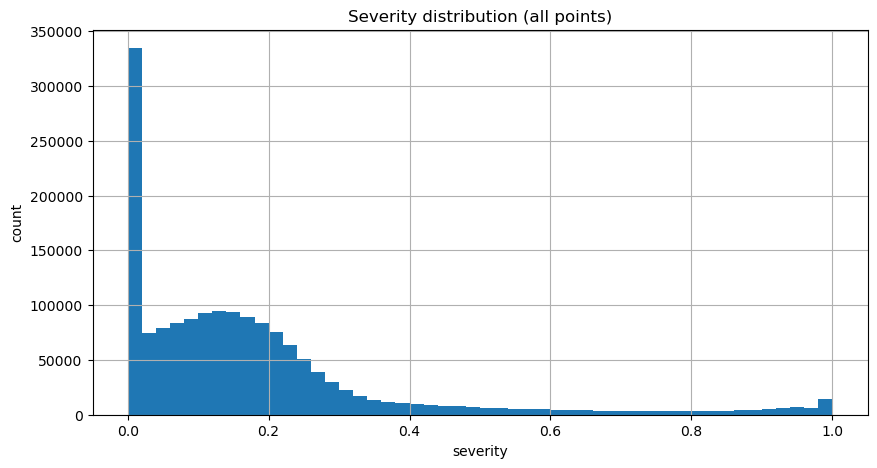

In [18]:
# %% Severity distribution (overall)

if "severity" not in df_scored.columns:
    raise ValueError("Expected column 'severity' in the scored output.")

severity = df_scored["severity"]

print(severity.describe())
print("\nQuantiles:")
print(severity.quantile([0.9, 0.95, 0.99, 0.999]))

plt.hist(severity, bins=50)
plt.title("Severity distribution (all points)")
plt.xlabel("severity")
plt.ylabel("count")
plt.show()


,count,mean,std,min,25%,50%,75%,max
synthetic_label,,,,,,,,
normal,1610015.0,0.179310,0.205300,0.000000,0.038355,0.131451,0.226015,1.0
syn_collective_dip,1924.0,0.886209,0.219107,0.064628,0.917770,1.000000,1.000000,1.0
syn_high_noise,300.0,0.267417,0.301736,0.000000,0.043585,0.129721,0.536223,1.0
syn_point_spike,100.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0
syn_stuck,300.0,0.418133,0.389164,0.000000,0.013019,0.341759,0.952898,1.0


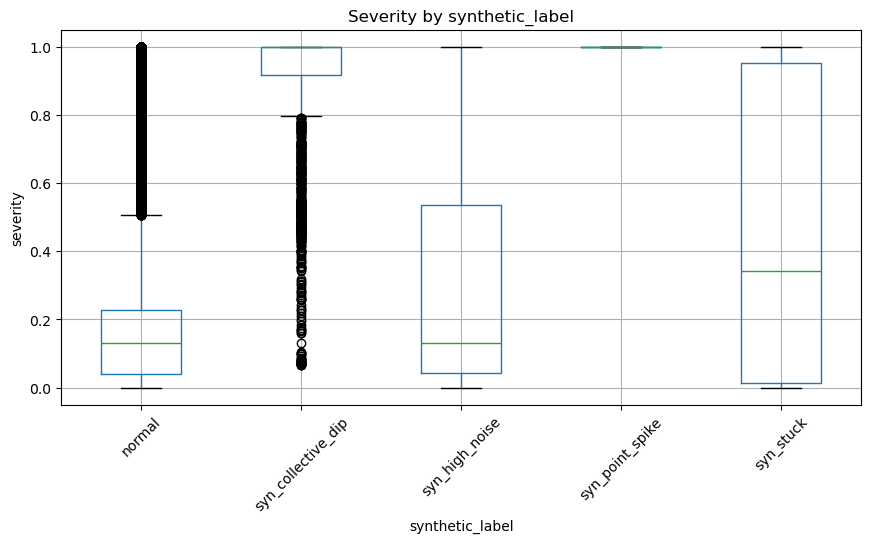

In [19]:
# %% Severity by synthetic label (if available)

if "synthetic_label" in df_scored.columns:
    label_stats = df_scored.groupby("synthetic_label")["severity"].describe()
    display(label_stats)

    df_scored.boxplot(column="severity", by="synthetic_label", rot=45)
    plt.title("Severity by synthetic_label")
    plt.suptitle("")
    plt.xlabel("synthetic_label")
    plt.ylabel("severity")
    plt.show()
else:
    print("No 'synthetic_label' column found; skipping per-label severity analysis.")


In [20]:
# %% Global detection metrics vs synthetic labels

if "synthetic_label" in df_scored.columns:
    is_anom = df_scored["synthetic_label"] != "normal"
    total_anom = is_anom.sum()
    total_norm = (~is_anom).sum()
    print("Total anomalies:", total_anom)
    print("Total normals:", total_norm)

    def confusion_at_threshold(th):
        pred = df_scored["severity"] >= th
        true = is_anom

        tp = (pred & true).sum()
        fp = (pred & ~true).sum()
        fn = (~pred & true).sum()
        tn = (~pred & ~true).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        return {
            "threshold": th,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "precision": precision,
            "recall": recall,
        }

    metrics = [confusion_at_threshold(th) for th in [0.5, 0.7, 0.9, 0.95]]
    pd.DataFrame(metrics)
else:
    print("No 'synthetic_label' column found; skipping detection metrics.")


Total anomalies: 2624
Total normals: 1610015


In [21]:
# %% Per-type detection at selected thresholds

if "synthetic_label" in df_scored.columns:
    def label_stats_at_threshold(th):
        pred = df_scored["severity"] >= th
        res = (
            df_scored.groupby("synthetic_label")
            .apply(lambda g: pd.Series({
                "count": len(g),
                "flagged": (g["severity"] >= th).sum(),
                "flagged_pct": (g["severity"] >= th).mean() * 100,
            }))
        )
        return res

    for th in [0.7, 0.9, 0.95]:
        print(f"=== threshold = {th} ===")
        display(label_stats_at_threshold(th))
else:
    print("No 'synthetic_label' column found; skipping per-type detection stats.")


=== threshold = 0.7 ===


,count,flagged,flagged_pct
synthetic_label,,,
normal,1610015.0,73896.0,4.589771
syn_collective_dip,1924.0,1561.0,81.133056
syn_high_noise,300.0,46.0,15.333333
syn_point_spike,100.0,100.0,100.000000
syn_stuck,300.0,89.0,29.666667


=== threshold = 0.9 ===


,count,flagged,flagged_pct
synthetic_label,,,
normal,1610015.0,37681.0,2.340413
syn_collective_dip,1924.0,1448.0,75.259875
syn_high_noise,300.0,11.0,3.666667
syn_point_spike,100.0,100.0,100.000000
syn_stuck,300.0,78.0,26.000000


=== threshold = 0.95 ===


,count,flagged,flagged_pct
synthetic_label,,,
normal,1610015.0,22102.0,1.372782
syn_collective_dip,1924.0,1424.0,74.012474
syn_high_noise,300.0,6.0,2.000000
syn_point_spike,100.0,100.0,100.000000
syn_stuck,300.0,76.0,25.333333


In [22]:
# %% Sub-score contributions by label

score_cols = [
    col for col in [
        "score_point",
        "score_collective",
        "score_context",
        "score_sensor_fault",
        "score_stuck",
        "score_spike",
        "score_noise",
    ]
    if col in df_scored.columns
]

if score_cols:
    display(df_scored[score_cols].describe())

    if "synthetic_label" in df_scored.columns:
        display(df_scored.groupby("synthetic_label")[score_cols].mean())
else:
    print("No score_* columns found; skipping sub-score analysis.")


,score_point,score_collective,score_context,score_sensor_fault,score_stuck,score_spike,score_noise
count,1.612494e+06,1.612199e+06,1.612639e+06,1.612639e+06,1.612494e+06,1.612639e+06,1.612494e+06
mean,2.058051e-02,9.429140e-02,1.284395e-02,8.554581e-02,7.974812e-02,5.799106e-04,5.327267e-03
std,7.478132e-02,8.803852e-02,8.903414e-02,2.097425e-01,2.002172e-01,1.984473e-02,6.725405e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,7.968399e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.583897e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,6.601244e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


,score_point,score_collective,score_context,score_sensor_fault,score_stuck,score_spike,score_noise
synthetic_label,,,,,,,
normal,0.020472,0.094224,0.011841,0.084800,0.079773,0.000507,0.004627
syn_collective_dip,0.059878,0.164898,0.786562,0.614226,0.022590,0.000000,0.591636
syn_high_noise,0.044763,0.079497,0.147124,0.065032,0.004596,0.060471,0.000000
syn_point_spike,0.996519,0.117665,0.911119,1.000000,0.000000,1.000000,0.030798
syn_stuck,0.000000,0.011026,0.000000,0.414301,0.414301,0.000000,0.000000


In [23]:
# %% Severity by sensor and label

if "sensor_id" in df_scored.columns:
    if "synthetic_label" in df_scored.columns:
        sev_by_sensor_label = (
            df_scored.groupby(["sensor_id", "synthetic_label"])["severity"]
            .describe()[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
        )
        display(sev_by_sensor_label)
    else:
        sev_by_sensor = df_scored.groupby("sensor_id")["severity"].describe()
        display(sev_by_sensor)
else:
    print("No 'sensor_id' column found; skipping per-sensor severity analysis.")


count      mean  \
sensor_id                             synthetic_label                          
System_10|EquipmentUnit_05|nan        normal              321878.0  0.249459   
                                      syn_collective_dip     421.0  0.868079   
                                      syn_high_noise          60.0  0.089764   
                                      syn_point_spike         20.0  1.000000   
                                      syn_stuck               60.0  0.964997   
System_10|EquipmentUnit_06|nan        normal              322282.0  0.208204   
                                      syn_collective_dip     467.0  0.967040   
                                      syn_high_noise          60.0  0.737807   
                                      syn_point_spike         20.0  1.000000   
                                      syn_stuck               60.0  0.333647   
System_10|EquipmentUnit_10|SubUnit_07 normal              322053.0  0.131008   
                                      syn_collective_dip     246.0  1.000000   
                                      syn_high_noise          60.0  0.099786   
                                      syn_point_spike         20.0  1.000000   
                                      syn_stuck               60.0  0.295914   
System_10|EquipmentUnit_10|SubUnit_08 normal              321923.0  0.095569   
                                      syn_collective_dip     376.0  0.747574   
                                      syn_high_noise          60.0  0.056369   
                                      syn_point_spike         20.0  1.000000   
                                      syn_stuck               60.0  0.460745   
System_10|EquipmentUnit_11|nan        normal              321879.0  0.212311   
                                      syn_collective_dip     414.0  0.871761   
                                      syn_high_noise          60.0  0.353361   
                                      syn_point_spike         20.0  1.000000   
                                      syn_stuck               60.0  0.035361   

                                                               std       min  \
sensor_id                             synthetic_label                          
System_10|EquipmentUnit_05|nan        normal              0.239009  0.000000   
                                      syn_collective_dip  0.211450  0.374035   
                                      syn_high_noise      0.138778  0.000000   
                                      syn_point_spike     0.000000  1.000000   
                                      syn_stuck           0.014472  0.952895   
System_10|EquipmentUnit_06|nan        normal              0.224686  0.000000   
                                      syn_collective_dip  0.116048  0.500243   
                                      syn_high_noise      0.121503  0.503738   
                                      syn_point_spike     0.000000  1.000000   
                                      syn_stuck           0.324360  0.000000   
System_10|EquipmentUnit_10|SubUnit_07 normal              0.165902  0.000000   
                                      syn_collective_dip  0.000000  1.000000   
                                      syn_high_noise      0.038938  0.031053   
                                      syn_point_spike     0.000000  1.000000   
                                      syn_stuck           0.320642  0.012800   
System_10|EquipmentUnit_10|SubUnit_08 normal              0.173087  0.000000   
                                      syn_collective_dip  0.237765  0.065583   
                                      syn_high_noise      0.119222  0.000000   
                                      syn_point_spike     0.000000  1.000000   
                                      syn_stuck           0.246316  0.218108   
System_10|EquipmentUnit_11|nan        normal              0.171622  0.000000   
                                      syn_collective_dip  0.

In [24]:
# %% Inspect top anomalies

cols_to_show = [
    col for col in [
        "time",
        "sensor_id",
        "oxygen",
        "synthetic_label",
        "score_point",
        "score_collective",
        "score_context",
        "score_sensor_fault",
        "severity",
    ]
    if col in df_scored.columns
]

df_scored.sort_values("severity", ascending=False).head(50)[cols_to_show]


,time,sensor_id,oxygen,synthetic_label,score_point,score_collective,score_context,score_sensor_fault,severity
391163,2025-05-19 11:09:00,System_10|EquipmentUnit_06|nan,102.743546,normal,1.0,0.062885,0.286208,0.00000,1.0
258552,2025-09-29 23:20:00,System_10|EquipmentUnit_05|nan,44.792183,normal,0.0,0.000000,1.000000,0.00000,1.0
258561,2025-09-29 23:29:00,System_10|EquipmentUnit_05|nan,43.653763,normal,0.0,0.000000,1.000000,0.00000,1.0
258560,2025-09-29 23:28:00,System_10|EquipmentUnit_05|nan,43.687569,normal,0.0,0.000000,1.000000,0.00000,1.0
258559,2025-09-29 23:27:00,System_10|EquipmentUnit_05|nan,43.956741,normal,0.0,0.000000,1.000000,0.00000,1.0
258558,2025-09-29 23:26:00,System_10|EquipmentUnit_05|nan,44.431652,normal,0.0,0.000000,1.000000,0.00000,1.0
258557,2025-09-29 23:25:00,System_10|EquipmentUnit_05|nan,44.704384,normal,0.0,0.000000,1.000000,0.00000,1.0
258556,2025-09-29 23:24:00,System_10|EquipmentUnit_05|nan,44.737724,normal,0.0,0.000000,1.000000,0.00000,1.0
258555,2025-09-29 23:23:00,System_10|EquipmentUnit_05|nan,44.770840,normal,0.0,0.000000,1.000000,0.00000,1.0
258554,2025-09-29 23:22:00,System_10|EquipmentUnit_05|nan,44.886265,normal,0.0,0.000000,1.000000,0.00000,1.0


In [25]:
df_scored.to_csv(processed_path)

In [26]:
df_scored

,time,sensor_id,oxygen,hour,dayofweek,synthetic_label,roll_mean,roll_std,z_global,score_point,...,ctx_std_hour,z_context,score_context,roll_std_long,score_stuck,score_spike,roll_std_noise,score_noise,score_sensor_fault,severity
0,2025-04-01 17:43:00,System_10|EquipmentUnit_05|nan,91.639549,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.679695,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.000000
1,2025-04-01 17:44:00,System_10|EquipmentUnit_05|nan,91.443474,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.646412,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.000000
2,2025-04-01 17:45:00,System_10|EquipmentUnit_05|nan,91.784111,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.704234,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.000000
3,2025-04-01 17:46:00,System_10|EquipmentUnit_05|nan,92.180275,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.771482,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.000000
4,2025-04-01 17:47:00,System_10|EquipmentUnit_05|nan,92.131180,17,1,normal,NaN,NaN,NaN,NaN,...,5.891127,0.763148,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612634,2025-11-14 09:27:00,System_10|EquipmentUnit_11|nan,85.481667,9,4,normal,83.634142,0.872716,2.116981,0.038994,...,5.999268,-0.407451,0.0,0.872716,0.0,0.0,0.872716,0.0,0.0,0.168845
1612635,2025-11-14 09:28:00,System_10|EquipmentUnit_11|nan,85.612083,9,4,normal,83.673079,0.907868,2.135775,0.045258,...,5.999268,-0.385712,0.0,0.907868,0.0,0.0,0.907868,0.0,0.0,0.170538
1612636,2025-11-14 09:29:00,System_10|EquipmentUnit_11|nan,85.724228,9,4,normal,83.713886,0.944015,2.129563,0.043188,...,5.999268,-0.367019,0.0,0.944015,0.0,0.0,0.944015,0.0,0.0,0.172094
1612637,2025-11-14 09:30:00,System_10|EquipmentUnit_11|nan,85.901230,9,4,normal,83.757643,0.983391,2.179789,0.059930,...,5.999268,-0.337515,0.0,0.983391,0.0,0.0,0.983391,0.0,0.0,0.173995


### Summary

- The improved pipeline keeps the original behaviour for **point**, **collective**,
  and **stuck** anomalies, while making the **high-noise** sensor-fault detection
  more sensitive via a quantile-based baseline and a slightly lower `noise_factor`.
- This should increase the severity for `syn_high_noise` segments without
  inflating false positives too much.
- The analysis section can be re-run on any future scored output by simply
  pointing `output_path` to the relevant CSV.
